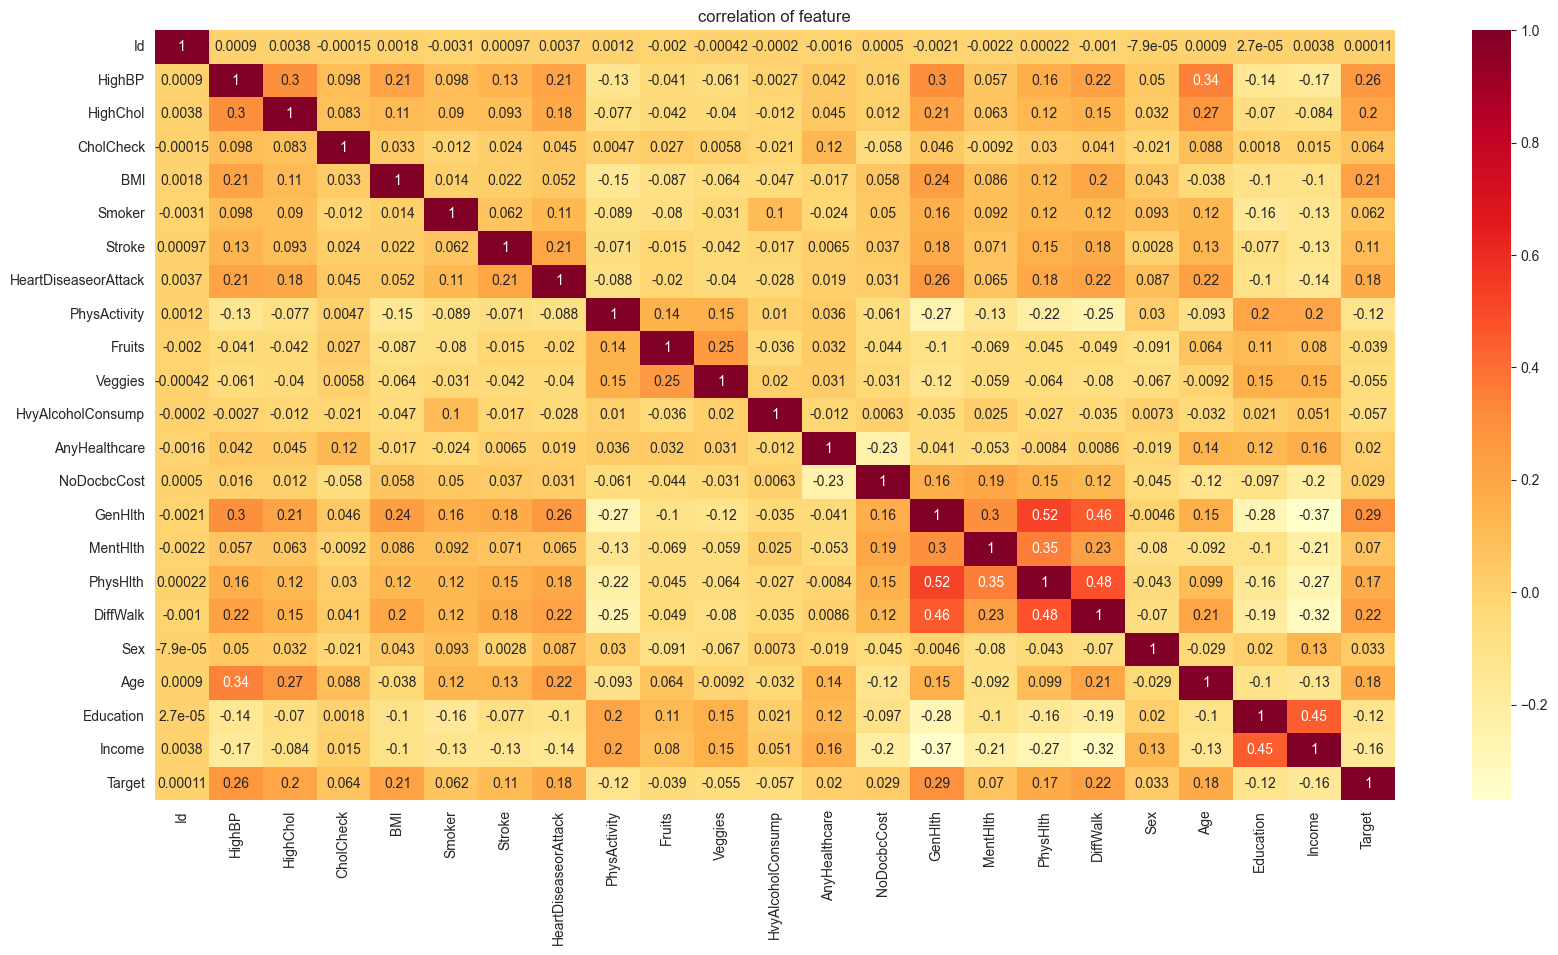

In [4]:
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.random import randint
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.inspection import permutation_importance
import joblib

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

plt.figure(figsize = (20,10))
sns.heatmap(train_data.corr(),annot=True , cmap ='YlOrRd' )
plt.title("correlation of feature")
plt.show()

# print(train_data.hist(figsize=(20,20)))

# columnsToDrop = ['Sex',
#                  'Education',
#                  'AnyHealthcare',
#                  'HighChol',
#                  'CholCheck',
#                  'HvyAlcoholConsump',
#                  'NoDocbcCost',
#                  'Smoker',
#                  'Stroke',
#                  'HeartDiseaseorAttack',
#                  'PhysHlth',
#                  'MentHlth',
#                  'Fruits',
#                  'Veggies',
#                  'DiffWalk'
#                  ]
# 
# train_data = train_data.drop(columns=columnsToDrop)
# test_data = test_data.drop(columns=columnsToDrop)

# categorical_cols = [
#     'Age',
#     # 'Sex',
#     'Income',
#     # 'Education'
# ] # here we will use OneHot (convert to numeric data)
# numerical_cols = [
#     'BMI',
#     # 'PhysHlth',
#     'GenHlth',
#     # 'MentHlth'
# ] # here we will use scaling to give a better representation
# # the rest of the columns are binary

numerical_cols = [
    'HighBP', 'HighChol', 'BMI', 'Smoker', 'Stroke',
    'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
    'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
    'MentHlth', 'PhysHlth', 'DiffWalk'
]
categorical_cols = ['CholCheck', 'Age','Sex','Education','Income']

def create_interactions(df):
    # Health Conditions Interactions
    df['HighBP_HighChol'] = df['HighBP'] * df['HighChol']
    df['HighBP_Age'] = df['HighBP'] * df['Age']
    df['HighBP_BMI'] = df['HighBP'] * df['BMI']
    df['HighBP_DiffWalk'] = df['HighBP'] * df['DiffWalk']
    df['HighChol_BMI'] = df['HighChol'] * df['BMI']
    df['HighBP_PhysHlth'] = df['HighBP'] * df['PhysHlth']
    df['HighBP_GenHlth'] = df['HighBP'] * df['GenHlth']
    # df['Gen_MentHlth'] = df['GenHlth'] * df['MentHlth']
    df['HeartDiseaseorAttack_PhysActivity'] = df['HeartDiseaseorAttack'] * df['PhysActivity']
    df['Smoker_HeartDiseaseorAttack'] = df['Smoker'] * df['HeartDiseaseorAttack']
    df['DiffWalk_HeartDiseaseorAttack'] = df['DiffWalk'] * df['HeartDiseaseorAttack']
    #Physical Activity and Lifestyle
    df['Fruits_Veggies'] = df['Fruits'] * df['Veggies']
    df['HvyAlcoholConsump_Smoker'] = df['HvyAlcoholConsump'] * df['Smoker']
    #General Health and Age
    df['BMI_Age'] = df['BMI'] * df['Age']
    df['BMI_DiffWalk'] = df['BMI'] * df['DiffWalk']
    df['DiffWalk_PhysHlth'] = df['DiffWalk'] * df['PhysHlth']
    df['GenHlth_Age'] = df['GenHlth'] * df['Age']
    df['HighBP_GenHlth_Age'] = df['HighBP'] * df['GenHlth'] * df['Age']
    df['PhysHlth_Age'] = df['PhysHlth'] * df['Age']
    # df['Smoker_Age'] = df['Smoker'] * df['Age']
    # df['GenHlth_Age2'] = df['GenHlth'] * df['Age']^2
    #Economic
    df['Income_AnyHealthcare'] = df['Income'] * df['AnyHealthcare']
    # df['Education_Income'] = df['Education'] * df['Income']
    
    return df

train_data = create_interactions(train_data)
test_data = create_interactions(test_data)

interactions_xgb = [
    'HighBP_HighChol',
    # 'HighBP_GenHlth_Age',
    # 'HighBP_DiffWalk',
    # 'HighBP_Age',
    # 'HighBP_BMI',
    # 'HighChol_BMI',
    # 'HighBP_PhysHlth',
    'HeartDiseaseorAttack_PhysActivity',
    # 'Smoker_HeartDiseaseorAttack',
    # 'HvyAlcoholConsump_Smoker',
    'DiffWalk_HeartDiseaseorAttack',
    'BMI_Age',
    'BMI_DiffWalk',
    'DiffWalk_PhysHlth',
    'GenHlth_Age',
    'PhysHlth_Age',
    'Income_AnyHealthcare',
]

interactions_lgbm = [
    # 'HighBP_HighChol',
    # 'HighBP_Age',
    # 'HighBP_BMI',
    # 'HighChol_BMI',
    # 'HighBP_PhysHlth',
    'HeartDiseaseorAttack_PhysActivity',
    # 'Smoker_HeartDiseaseorAttack',
    # 'DiffWalk_HeartDiseaseorAttack',
    # 'BMI_Age',
    # 'BMI_DiffWalk',
    # 'DiffWalk_PhysHlth',
    'GenHlth_Age',
    'PhysHlth_Age',
    'Income_AnyHealthcare',
    # 'Fruits_Veggies',
]

# Polynomial Features
# poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
# poly_features = ['BMI']
# 
# poly_train = pd.DataFrame(poly.fit_transform(train_data[poly_features]), 
#                        columns=poly.get_feature_names_out(poly_features))
# poly_test = pd.DataFrame(poly.fit_transform(test_data[poly_features]), 
#                        columns=poly.get_feature_names_out(poly_features))
# 
# train_data = pd.concat([train_data, poly_train.drop(columns=poly_features)], axis=1)
# test_data = pd.concat([test_data, poly_test.drop(columns=poly_features)], axis=1)
# 
# poly_cols = ['BMI^2']
numerical_cols += interactions_lgbm

# Binning BMI into categories
# LGBM, XGB
bins = [0, 18.5, 25, 30, np.inf]
labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
train_data['BMI_binned'] = pd.cut(train_data['BMI'], bins=bins, labels=labels)
test_data['BMI_binned'] = pd.cut(test_data['BMI'], bins=bins, labels=labels)

categorical_cols.append('BMI_binned')

# # Binning Age into categories
# # XGB
# bins_age = [0, 4, 6, 8, 10, 13]
# labels_age = ['Young Adults', 'Middle-aged Adults', 'Older Adults', 'Senior Adults', 'Elderly Adults']
# train_data['Age_binned'] = pd.cut(train_data['Age'], bins=bins_age, labels=labels_age, right=False)
# test_data['Age_binned'] = pd.cut(test_data['Age'], bins=bins_age, labels=labels_age, right=False)
# 
# categorical_cols.append('Age_binned')

numericalColumnsToDrop = [
    # 'BMI',
    # 'Fruits',
    # 'Veggies',
    # 'NoDocbcCost',
    'AnyHealthcare', #LGBM
    # 'PhysHlth',
]
categoricalColumnsToDrop = [
    # 'Age',
    # 'Income',
]

for e in numericalColumnsToDrop:
    numerical_cols.remove(e)

for e in categoricalColumnsToDrop:
    categorical_cols.remove(e)

numericalColumnsToDrop.extend(categoricalColumnsToDrop)
train_data = train_data.drop(columns=numericalColumnsToDrop)
test_data = test_data.drop(columns=numericalColumnsToDrop)

X = train_data.drop(columns=['Target'])
y = train_data['Target']

# X = X.head(10000)
# y = y.head(10000)

X_apply = test_data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=27)

In [ ]:
# label_encoder = LabelEncoder()
# for col in categorical_cols:
#     X_train[col] = label_encoder.fit_transform(X_train[col])
#     X_val[col] = label_encoder.transform(X_val[col])
# 
# # 4. Feature Extraction
# pca = PCA(n_components=10)
# X_train_pca = pca.fit_transform(X_train)
# X_val_pca = pca.transform(X_val)
# 
# # 5. Feature Selection
# select_k_best = SelectKBest(f_classif, k=30)  # Select top 50 features
# X_train_selected = select_k_best.fit_transform(X_train, y_train)
# X_val_selected = select_k_best.transform(X_val)
# 
# # Train the model again with selected/engineered features
# clf = XGBClassifier(
#         scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), 
#         random_state=27,
#         n_estimators=500,
#         subsample=0.9,
#         min_child_weight=10,
#         max_depth=5,
#         learning_rate=0.01,
#         gamma=0.2,
#         colsample_bytree=0.7,
#     )
# clf.fit(X_train_selected, y_train)
# 
# # Evaluate performance
# val_predictions = clf.predict(X_val_selected)
# val_score = balanced_accuracy_score(y_val, val_predictions)
# 
# print(f"Balanced Accuracy Score on Validation: {val_score}")
# print(classification_report(y_val, val_predictions))
# 
# # Apply the same transformation to the test/apply set
# X_apply_selected = select_k_best.transform(X_apply)
# 
# # Apply the model to the application/test set
# apply_predictions = clf.predict(X_apply_selected)
# 
# # Cross-Validation Check (Optional but recommended)
# cv_scores = cross_val_score(clf, X_train_selected, y_train, cv=5, scoring='balanced_accuracy')
# print(f'Cross-validated Balanced Accuracy Scores: {cv_scores}')
# print(f'Mean Cross-validated Balanced Accuracy Score: {np.mean(cv_scores)}')

In [ ]:
# sns.pairplot(train_data.head(100), hue='Target', palette='coolwarm', vars=['BMI','PhysHlth_BMI', 'PhysHlth_GenHlth_Age', 'BMI_GenHlth_Age'])
# plt.show()

In [503]:
# # Scatter matrix
# scatter_matrix(train_data[['BMI_GenHlth_Age', 'HighBP', 'HighChol', 'Target']], figsize=(12, 12), diagonal='kde', color='blue')
# plt.suptitle('Scatter Matrix of Key Features and Target', y=0.92)
# plt.show()

In [ ]:
# # Define the scatter plot function
# def scatter_plot(df, x_col, y_col, color_col, title):
#     plt.figure(figsize=(8, 6))
#     scatter = plt.scatter(df[x_col], df[y_col], c=df[color_col], cmap='coolwarm', alpha=0.6)
#     plt.colorbar(scatter, label=color_col)
#     plt.title(title)
#     plt.xlabel(x_col)
#     plt.ylabel(y_col)
#     plt.show()
# 
# # Create scatter plots for selected features
# scatter_plot(train_data, 'GenHlth_Age', 'BMI', 'Target', 'GenHlth_Age vs. BMI colored by Target')
# scatter_plot(train_data, 'PhysHlth', 'GenHlth_Age', 'Target', 'PhysHlth vs. GenHlth_Age colored by Target')
# scatter_plot(train_data, 'BMI', 'PhysHlth', 'Target', 'BMI vs. PhysHlth colored by Target')

In [5]:

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# xgb = (XGBClassifier(
#     scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), 
#     random_state=27,
#     n_estimators=875,
#     subsample=0.9,
#     min_child_weight=12,
#     max_depth=5,
#     learning_rate=0.01,
#     gamma=0.2,
#     colsample_bytree=0.7,
#     colsample_bylevel=1,
#     colsample_bynode=1,
#     reg_alpha=0,
#     reg_lambda=1,
# ))

lgbm = lgb.LGBMClassifier(
    class_weight='balanced', 
    n_estimators=1000, 
    learning_rate=0.02,
    max_depth=5,
    num_leaves=9,
    min_child_samples=9,
    subsample=1,
    colsample_bytree=0.2,
    reg_alpha=1,
    reg_lambda=1,
    scale_pos_weight=1,
)

rf = RandomForestClassifier(
    random_state=27, 
    class_weight='balanced', 
    criterion='entropy',
    n_estimators=400,
    max_depth=14,
    min_samples_split=10,
    min_samples_leaf=4
)
# 
# logreg = LogisticRegression(
#     class_weight='balanced', 
#     solver='liblinear',
#     penalty='l2',
#     C=1,
#     max_iter=1000,
#     random_state=27,
# )

model = ImbPipeline([
    ('preprocessor', preprocessor),
    # ('feature_selection', SelectKBest(f_classif, k=10)),  # Select top 50 features
    # ('smote', SMOTE(random_state=27)),
    # ('sampling', RandomUnderSampler(random_state=27)),
    # ('sme', SMOTEENN(random_state=27)),
    ('classifier', lgbm),
    # ('classifier', LogisticRegression(
    #     class_weight='balanced', 
    #     random_state=27,
    #     solver='liblinear',
    #     max_iter=10000,
    #     C=1,
    #     penalty='l2',
    # )),
    # ('classifier', lgb.LGBMClassifier(
    #     class_weight='balanced', 
    #     n_estimators=1000, 
    #     learning_rate=0.02,
    #     max_depth=5,
    #     num_leaves=9,
    #     min_child_samples=9,
    #     subsample=1,
    #     colsample_bytree=0.2,
    #     reg_alpha=1,
    #     reg_lambda=1,
    #     scale_pos_weight=1,
    # )),
    # ('classifier', AdaBoostClassifier(
    #     algorithm='SAMME',
    #     random_state=27,
    #     n_estimators=100,
    #     learning_rate=0.5,
    # )),

])

# base_learners = [
#     ('xgb', Pipeline([
#         ('preprocessor', preprocessor),
#         ('classifier', xgb)
#     ])),
#     ('lgbm', Pipeline([
#         ('preprocessor', preprocessor),
#         ('classifier', lgbm),
#     ])),
#     # ('rf', Pipeline([
#     #     ('preprocessor', preprocessor),
#     #     ('classifier', rf),
#     # ])),
#     # ('logreg', Pipeline([
#     #     ('preprocessor', preprocessor),
#     #     ('classifier', logreg),
#     # ])),
# ]
# 
# model = StackingClassifier(
#     estimators=base_learners,
#     final_estimator=logreg,
#     passthrough=False,
#     cv=5
# )

# param_dist = {
#     'classifier__n_estimators': [100, 200, 300, 400, 500],
#     'classifier__criterion': ['gini', 'entropy'],
#     'classifier__max_depth': [10, 20, 30, None],
#     'classifier__min_samples_split': [2, 5, 10],
#     'classifier__min_samples_leaf': [1, 2, 4],
#     'classifier__bootstrap': [True, False]
# }

# Define parameter grid for XGBClassifier
# param_dist = {
#     'classifier__n_estimators': [100, 200, 300, 500, 700, 1000],
#     'classifier__max_depth': [3, 5, 8, 10, 15, 20, 30],
#     'classifier__learning_rate': [0.01, 0.1, 0.2, 0.3],
#     'classifier__subsample': [0.7, 0.8, 0.9, 1.0],
#     'classifier__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
#     'classifier__gamma': [0, 0.1, 0.2, 0.3],
#     'classifier__min_child_weight': [1, 4, 6, 10]
# }
# 
# param_dist = {
#     'classifier__scale_pos_weight': [6.120, 6.121, 6.122, 6.123, 6.124, 6.125, 6.126],
# }

# param_dist = {
#     'logreg__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
#     'logreg__penalty': ['l1', 'l2'],  # Regularization type
#     'logreg__class_weight': [None, 'balanced']  # Class weight balancing
# }

# param_grid = {
#     'classifier__learning_rate': [0.01, 0.1],
#     'classifier__n_estimators': [100, 200],
#     'classifier__max_depth': [10, 20, 30],
#     'classifier__subsample': [0.8, 1.0],
#     'classifier__colsample_bytree': [0.8, 1.0]
# }
# 
# grid_search = GridSearchCV(model, param_dist, cv=2, scoring='balanced_accuracy', verbose=2)
# grid_search.fit(X_train, y_train)
# 
# print("Best parameters found: ", grid_search.best_params_)
# print("Best balanced accuracy score: ", grid_search.best_score_)

# random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, 
#                                     n_iter=2, cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=1, random_state=27)
# random_search.fit(X_train, y_train)
# 
# # Get the best parameters
# best_params = random_search.best_params_
# print(f'Best parameters found: {best_params}')
# 
# # Retrain the model with the best parameters
# best_model = random_search.best_estimator_
# 
# # Evaluate the best model
# predictions = best_model.predict(X_test)
# score = balanced_accuracy_score(y_test, predictions)
# 
# print(f'Balanced Accuracy Score with best parameters: {score}')
# print(classification_report(y_test, predictions))

model.fit(X_train,y_train)

predictions = model.predict(X_test)
val_score = balanced_accuracy_score(y_test, predictions)
print(f"Balanced Accuracy Score on Validation: {val_score}")
print(classification_report(y_test, predictions))

[LightGBM] [Info] Number of positive: 17313, number of negative: 106990
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 453
[LightGBM] [Info] Number of data points in the train set: 124303, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Balanced Accuracy Score on Validation: 0.7516650053068579
              precision    recall  f1-score   support

           0       0.95      0.71      0.82     45798
           1       0.31      0.79      0.45      7475

    accuracy                           0.72     53273
   macro avg       0.63      0.75      0.63     53273
weighted avg       0.86      0.72      0.76     53273



In [7]:
# joblib.dump(model, 'diabeticPredictor-STACK_acc=0.75177')

# Evaluate the model on the validation set
predictions = model.predict(X_test)
predictions_a = model.predict(X_apply)

# Calculate the optimal threshold on your validation set
# precision, recall, thresholds = precision_recall_curve(y_val, y_pred_val_proba)
# optimal_threshold = thresholds[np.argmax(precision + recall)]
# print(f'Optimal threshold found: {optimal_threshold}')
# optimal_threshold = 0.5

# Evaluate using optimal threshold
# val_predictions = (y_pred_val_proba > optimal_threshold).astype(int)
val_score = balanced_accuracy_score(y_test, predictions)
# submission_df = pd.DataFrame({
#     'Id': X_apply['Id'],  # Assuming 'Id' is the name of the ID column in X_apply
#     'Target': predictions
# })
# 
# # Save the predictions to a CSV file
# submission_df.to_csv('submission-rf_19-09-24.csv', index=False)

print(f"Balanced Accuracy Score on Validation: {val_score}")
print(classification_report(y_test, predictions))
# 
# # Apply the threshold to the application set
# y_pred_proba_apply = model.predict_proba(X_test)[:, 1]
# apply_predictions = (y_pred_proba_apply > optimal_threshold).astype(int)
# 
# Confirming the predictions
submission_df = pd.DataFrame({
    'Id': X_apply['Id'],  # Ensure 'Id' is indeed the correct identifier field in your dataset
    'Target': predictions_a
})

# Save the predictions to a CSV file
submission_df.to_csv('submission-rf_20-09-24.csv', index=False)

# # Optional: Print some of the predictions to verify
# print(submission_df.head())
# 
from sklearn.model_selection import cross_val_score

# Calculate cross-validated scores with the balanced accuracy scoring metric
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='balanced_accuracy')
print(f'Cross-validated Balanced Accuracy Scores: {cv_scores}')
print(f'Mean Cross-validated Balanced Accuracy Score: {np.mean(cv_scores)}')

Balanced Accuracy Score on Validation: 0.7516650053068579
              precision    recall  f1-score   support

           0       0.95      0.71      0.82     45798
           1       0.31      0.79      0.45      7475

    accuracy                           0.72     53273
   macro avg       0.63      0.75      0.63     53273
weighted avg       0.86      0.72      0.76     53273

[LightGBM] [Info] Number of positive: 13850, number of negative: 85592
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 450
[LightGBM] [Info] Number of data points in the train set: 99442, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 13850, number of neg

In [ ]:
# # joblib.dump(model, 'diabeticPredictor-RF_acc=0.94055_th=0.47305.joblib')
# # model = joblib.load('diabeticPredictor-RF_50107.joblib')
# 
# predictions = model.predict(X_test)
# # score = balanced_accuracy_score(y_test, predictions)
# 
# # print(score)
# # print(classification_report(y_test, predictions))
# 
# threshold = 0.47305
# 
# y_pred_proba = model.predict_proba(X_test)[:, 1]
# predictions = (y_pred_proba > threshold).astype(int)
# 
# # submission_df = pd.DataFrame({
# #     'Id': X_apply['Id'],  # Assuming 'Id' is the name of the ID column in X_apply
# #     'Target': predictions
# # })
# # 
# # # Save the predictions to a CSV file
# # submission_df.to_csv('submission-rf_19-09-24.csv', index=False)
# 
# # # Print classification report (for your validation data)
# X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
# 
# # Evaluate the model with the validation set
# y_pred_val_proba = model.predict_proba(X_val)[:, 1]
# val_predictions = (y_pred_val_proba > threshold).astype(int)
# val_score = balanced_accuracy_score(y_val, val_predictions)
# 
# # Output evaluation metrics for validation data
# print(f"Balanced Accuracy Score on Validation: {val_score}")
# print(classification_report(y_val, val_predictions))

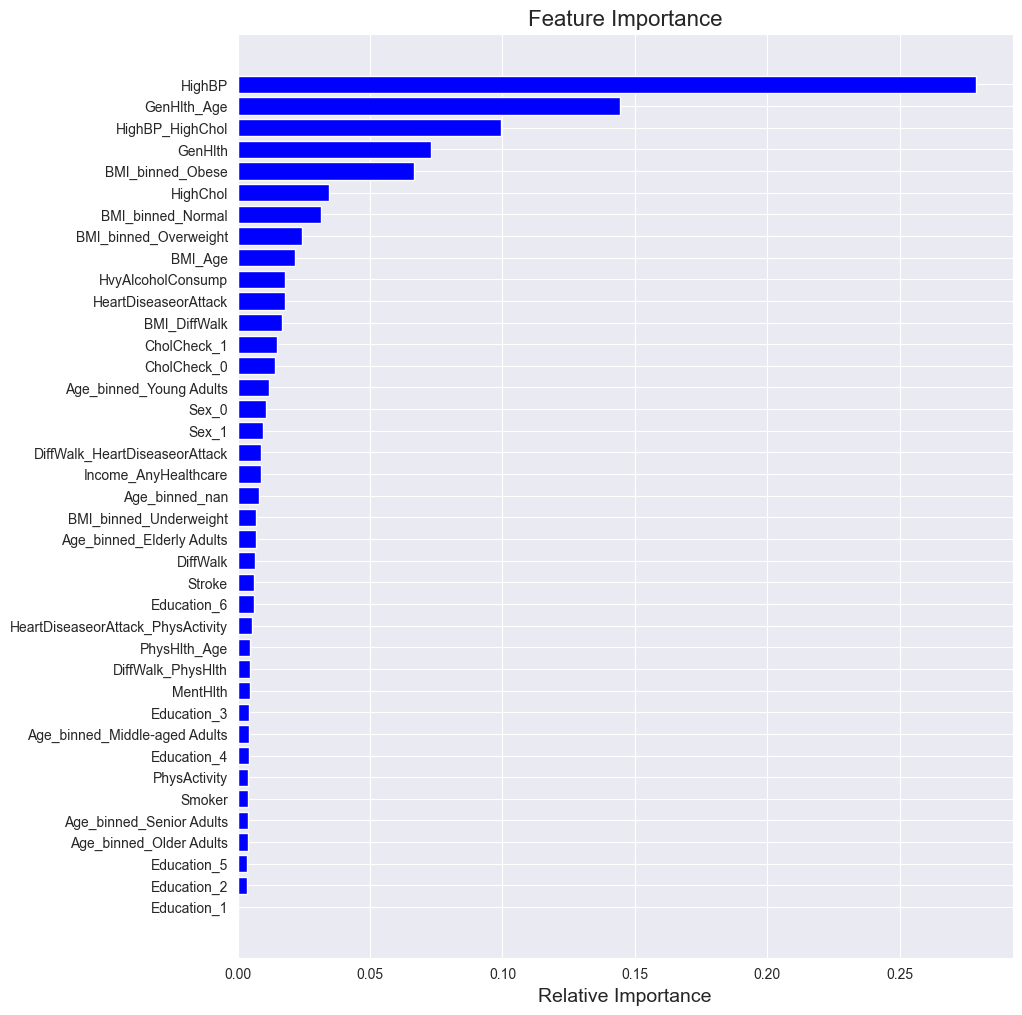

In [810]:
feature_importances = model.named_steps['classifier'].feature_importances_
feature_names = preprocessor.transformers_[0][2] + list(preprocessor.transformers_[1][1].get_feature_names_out(categorical_cols))

# Sort features by importance
indices = np.argsort(feature_importances)

plt.figure(figsize=(10, 12))
plt.title("Feature Importance", fontsize=16)
plt.barh(range(len(indices)), feature_importances[indices], color="b", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance", fontsize=14)
plt.show()

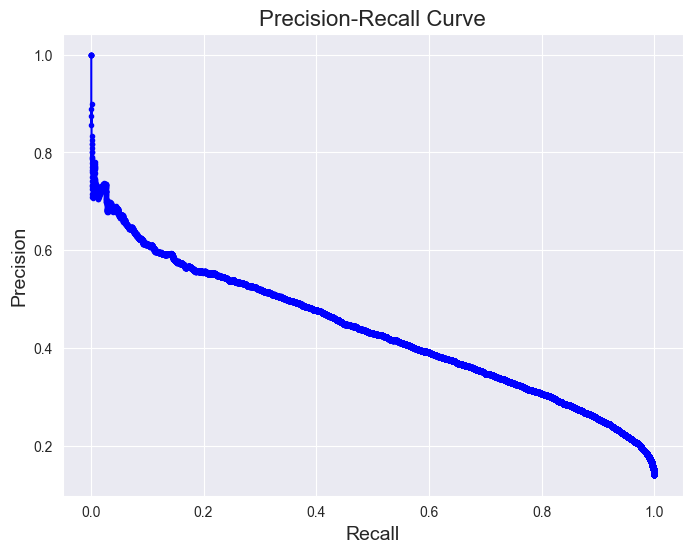

In [620]:
predictions = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, predictions)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', color='b')
plt.title('Precision-Recall Curve', fontsize=16)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
# predictions = model.predict_proba(X_test)[:, 1]
# conf_matrix = confusion_matrix(y_test, predictions)
# 
# plt.figure(figsize=(6, 5))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.title('Confusion Matrix', fontsize=16)
# plt.ylabel('True Label', fontsize=14)
# plt.xlabel('Predicted Label', fontsize=14)
# plt.show()

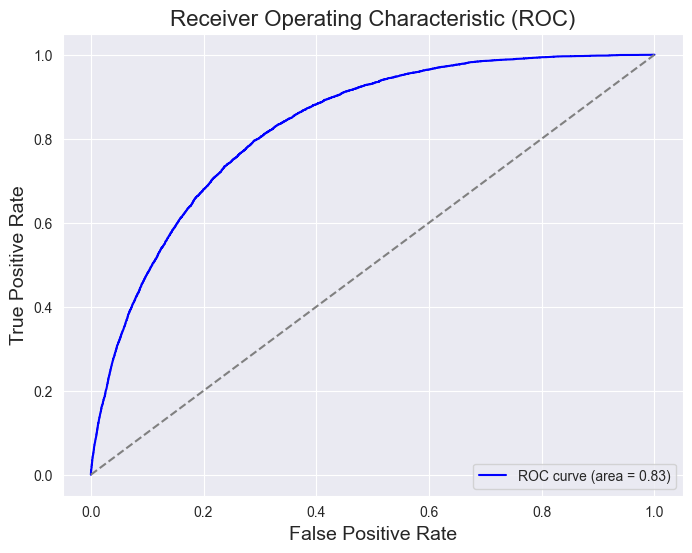

In [362]:
predictions = model.predict_proba(X_test)[:, 1]

fpr, tpr, threshold = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

TypeError: unsupported format string passed to numpy.ndarray.__format__

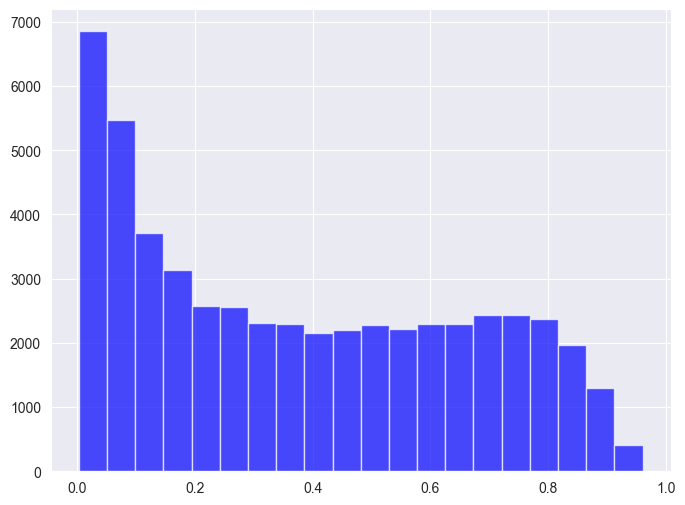

In [363]:
predictions = model.predict_proba(X_test)[:, 1]

plt.figure(figsize=(8, 6))
plt.hist(predictions, bins=20, color='b', alpha=0.7, label='Predicted Probabilities')
plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.3f}')
plt.title('Distribution of Predicted Probabilities', fontsize=16)
plt.xlabel('Predicted Probability', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.show()